# Análisis exploratorio de los datos preliminares de GoFoundMe

En este cuaderno se muestra la exploración de datos que fueron obtenidos mediante *web scrapping* de GoFoundMe.

Primero, importamos las bibliotecas que usaremos:

In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from currency_converter import CurrencyConverter
c = CurrencyConverter()

In [81]:
# Para usar el estilo por defecto de seaborn
sns.set(rc={'figure.figsize':(11, 5)})

y cargamos los datos que se van a analizar:

In [82]:
df = pd.read_pickle('../datos/GoFundMeData_VenezuelaCovid_20210421.pkl').explode('tags')
df['launch_date'] = pd.to_datetime(df['launch_date'])

#covertimos los tags en strings
df = df.explode('tags')

#filtramos fechas que no corresponden a nuestro rango de interés
filtro = df['launch_date'] > '2020-01-01'
df = df[filtro]

df.head() #echamos un primer vistazo

,url,title,tags,current amount,total_amount,description,created,launch_date,country,donation_count,is_charity
0,https://www.gofundme.com/f/help-otsmars-parent...,Help Otsmar's parents beat Covid-19,"Medical, Illness & Healing","$17,550","$50,000",Sara Schlesinger is organizing this fundraiser...,"Created April 2, 2021",2021-04-02,US,174,false
1,https://www.gofundme.com/f/ecuador-covid19-foo...,Ecuador & Venezuela COVID-19 Food Relief,Volunteer & Service,"$5,730","$6,000",Team fundraiserKirsten Chaplin and 3 others ar...,"Created April 13, 2020",2020-04-13,US,148,false
2,https://www.gofundme.com/f/support-venezuelas-...,Support the Venezuelan COVID-19 Crisis,"Medical, Illness & Healing","$5,350","$5,000",Team fundraiserAlessandra Feuerberg and 2 othe...,"Created April 25, 2020",2020-04-25,US,142,false
3,https://www.gofundme.com/f/pccwcc-williams-med...,Williams' Medical Expenses,"Medical, Illness & Healing","$3,239","$8,000",Team fundraiserRoselyn Vasquez and Jennifer Kn...,"Created April 6, 2021",2021-04-06,US,37,false
4,https://www.gofundme.com/f/help-animals-withou...,Help homeless animals in Venezuela COVID-19,Animals & Pets,"€1,050","€1,800",Christian Vielma is organizing this fundraiser...,"Created July 5, 2020",2020-07-05,US,32,false


Variables de interés:
* Distribución de paises.
* Distribución de tags.
* Distribución del monto actual, monto total, número de donantes y porcentaje recaudado.
* Serie de tiempo de nuevas campañas, monto total y monto total por campaña.
* Relacionar el número de días de campaña con monto actual, número de donantes y porcentaje recaudado.

Separar por tags cuando se pueda.

## Distribución de paises:

In [83]:
#veamos la tabla:
#df.groupby(['country']).count()[['url']]

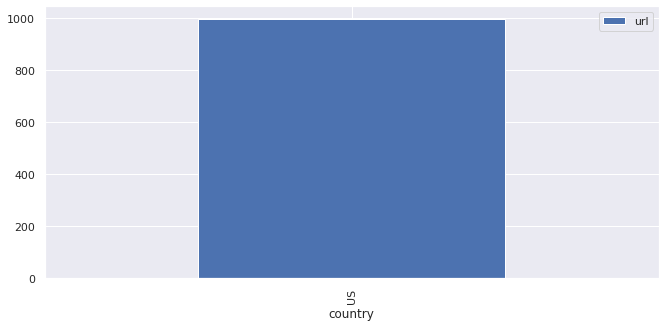

In [84]:
#visualicemos la distribución de paises
df.groupby(['country']).count().reset_index().plot(x = 'country', y = 'url', kind = 'bar')
plt.show()

Todas las campañas de la tabla provienen de estados unidos.

## Distribución de tags:

In [85]:
# veamos la tabla
#df.groupby('tags').count()[['url']]

[]

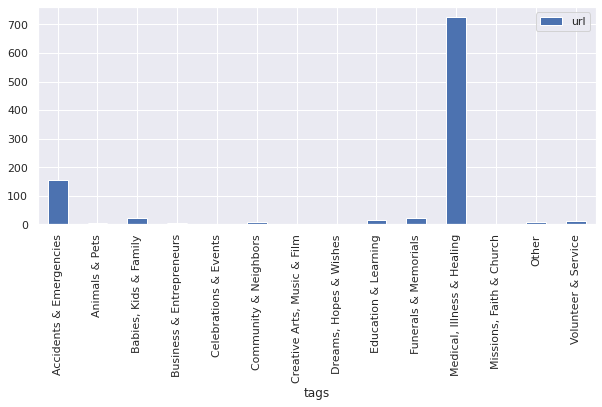

In [86]:
# visualicemos la distribución de tags
df.groupby('tags').count().reset_index().plot(x = 'tags', y = 'url', kind = 'bar', figsize = (10, 4))
plt.plot()

## Número de campañas 

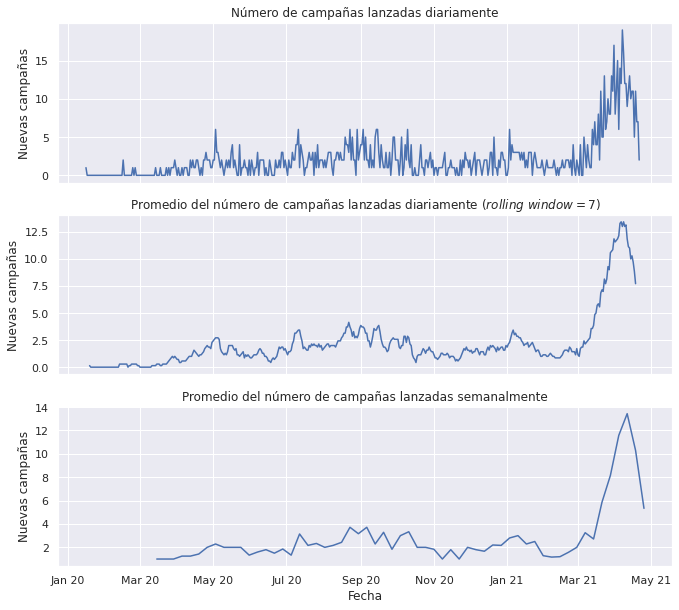

In [87]:
serie_campaña= pd.to_datetime(df['launch_date']).value_counts() # Creamos una serie de tiempo a partir de los datos

#tomamos muestras semanales y calculamos el promedio sobre estas muestra
serie_diaria = serie_campaña.resample('D').sum()
serie_rolling = serie_diaria.rolling(window=7, center=True).mean()
serie_semanal = serie_campaña.resample('W').mean()

#Graficamos la serie de tiempo
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

#serie_diaria
axes[0].plot(serie_diaria)
axes[0].set_title('Número de campañas lanzadas diariamente')

#serie_rolling
axes[1].plot(serie_rolling)
axes[1].set_title(r'Promedio del número de campañas lanzadas diariamente $(rolling$ $window=7) $')

#serie_semanal
axes[2].plot(serie_semanal)
axes[2].set_title(r'Promedio del número de campañas lanzadas semanalmente')

# Dar formato a las fechas
for ax in axes:
    ax.set_ylabel('Nuevas campañas') #agregamos label en el eje y

axes[2].set_xlabel('Fecha')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.tight_layout
plt.show()

## Distribución de dinero colectado y total:

### Limpieza de divisas

Antes que todo, verifiquemos que los datos estén completos:

In [88]:
# sub df de datos con valores nulos para la variable 'total_amount'
df[pd.isnull(df['total_amount'])]

,url,title,tags,current amount,total_amount,description,created,launch_date,country,donation_count,is_charity


Vemos que no hace falta ningún valor. 

Algo de lo que nos percatamos es que el dinero no se solicita en la misma divisa. Para solucionar esto, se identifican los signos de todas las divisas presentes en nuestros datos. En este orden de ideas, se crea una función que recibe una lista/arreglo/serie de cantidades de dinero expresadas en diferentes divisas y devuelve la lista de símbolos de cada una de estas divisas:

In [89]:
def lista_signos(dinero):
    signos = []
    for string in dinero:
        signo = ''
        string = str(string)
        for char in string:
            if char.isnumeric():
                break
            else:
                signo += char
        if signo == '':
            signo = 'no registra'
        signos.append(signo) 
    return signos

Ahora, identificamos los símbolos para las cantidades de dinero en las columnas: *current amount*, *total_amount*

In [90]:
#current amount
signos_current = np.array(lista_signos(df['current amount']))

#total_amount
signos_total = np.array(lista_signos(df['total_amount']))

#veamos cuáles signos se encuentra en cada caso
print(set(signos_current), set(signos_total))

{'kr', '€', 'CHF', '£', '$', 'no registra'} {'kr', '€', 'CHF', '£', '$'}


Exploremos las filas que no registran valor en la columna *current amount*:

In [91]:
df[signos_current == 'no registra'].head()

,url,title,tags,current amount,total_amount,description,created,launch_date,country,donation_count,is_charity
60,https://www.gofundme.com/f/help-roberto039s-ho...,Help Roberto's Hospitalization from COVID19,"Medical, Illness & Healing","1,796",$,Alejandro Diaz is organizing this fundraiser.U...,"Created July 29, 2020",2020-07-29,US,51,false
71,https://www.gofundme.com/f/familia-cedeo-covid...,"FAMILIA CEDEÑO, COVID-19 - VENEZUELA","Medical, Illness & Healing",140,$,ANDRES MARIN is organizing this fundraiser.Cre...,"Created April 11, 2021",2021-04-11,US,10,false
75,https://www.gofundme.com/f/ayudemos-a-freddy-a...,Ayudemos a Freddy a vencer el cáncer,"Medical, Illness & Healing",142,€,Leonardo Fernandez is organizing this fundrais...,"Created February 18, 2021",2021-02-18,US,7,false
121,https://www.gofundme.com/f/jose-luis-covid19-r...,Ayudemos a José Luis a vencer el Covid-19!,"Medical, Illness & Healing","4,468",£,Xania Rodriguez is organizing this fundraiser....,"Created October 8, 2020",2020-10-08,US,105,false
425,https://www.gofundme.com/f/fondos-para-roxanna...,Fondos para Roxanna Vivas gastos médico,Accidents & Emergencies,"9,430",$,Alfredo Casanova is organizing this fundraiser...,"Created April 6, 2021",2021-04-06,US,122,false


Para los demás filas, verifiquemos que los signos de ambas columnas concuerdan:

In [92]:
# filtro para las columnas en las que sí se registra el signo en la columna: current amount
filtro = np.array(signos_current) != 'no registra'

sum(signos_current[filtro] != signos_total[filtro]) # el resultado de esta suma es el número de filas con incongruencias

0

Vemos que en todas las demás filas concuerdan, por lo tanto, se asumirá que la divisa que se utiliza en la columna *current amount* es la misma que se usa en la columna *total_amount*. Con esta información, se modificará el DataFrame para que sea más fácil generar resultados. Los cambios que se planean hacer son los siguientes:
1. Agregar una columna en donde se señale la divisa que se usa en la campaña.
2. Modificar las columnas *current amount* y *total_amount* para que cada entrada corresponda a un valor numérico.
3. Agregar dos columnas: *current amount in dollars*, *total amount in dollars* con los valores monetarios en dolares.
Cabe mencionar, que para cumplir estos objetivos se usará la biblioteca `currency_converter`.

Empezamos con el primer punto:

In [93]:
monedas = []
for signo in signos_total:
    if signo == 'CHF':
        monedas.append('CHF')
    elif signo == 'kr':
        monedas.append('SEK')
    elif signo == '$':
        monedas.append('USD')
    elif signo == '£':
        monedas.append('GBP')
    elif signo == '€':
        monedas.append('EUR')

#agregamos la columna de códigos
df.insert(5, 'currency used', monedas)

Para el segundo punto, creamos una función:

In [94]:
def modificar_columna_dinero(DataFrame, nombre_columna, signos):
    lista = DataFrame[nombre_columna]
    n = len(lista)
    for i in range(n):
        valor = lista.iloc[i]
        valor = valor.replace(signos[i], '').replace(',', '') #quitamos el signo y la coma
        if valor.isnumeric():
            valor = int(valor)
        else:
            valor = np.nan # sabemos que los único nan que estén presentes en los datos
                           # serán los que se agreguen en este paso.
        lista.iloc[i] = valor

In [96]:
# con la función que creamos, modificamos las columnas
modificar_columna_dinero(df, 'current amount', signos_current)
modificar_columna_dinero(df, 'total_amount', signos_total)

AttributeError: 'int' object has no attribute 'replace'

In [99]:
df

,url,title,tags,current amount,total_amount,currency used,description,created,launch_date,country,donation_count,is_charity
0,https://www.gofundme.com/f/help-otsmars-parent...,Help Otsmar's parents beat Covid-19,"Medical, Illness & Healing",17550,50000,USD,Sara Schlesinger is organizing this fundraiser...,"Created April 2, 2021",2021-04-02,US,174,false
1,https://www.gofundme.com/f/ecuador-covid19-foo...,Ecuador & Venezuela COVID-19 Food Relief,Volunteer & Service,5730,6000,USD,Team fundraiserKirsten Chaplin and 3 others ar...,"Created April 13, 2020",2020-04-13,US,148,false
2,https://www.gofundme.com/f/support-venezuelas-...,Support the Venezuelan COVID-19 Crisis,"Medical, Illness & Healing",5350,5000,USD,Team fundraiserAlessandra Feuerberg and 2 othe...,"Created April 25, 2020",2020-04-25,US,142,false
3,https://www.gofundme.com/f/pccwcc-williams-med...,Williams' Medical Expenses,"Medical, Illness & Healing",3239,8000,USD,Team fundraiserRoselyn Vasquez and Jennifer Kn...,"Created April 6, 2021",2021-04-06,US,37,false
4,https://www.gofundme.com/f/help-animals-withou...,Help homeless animals in Venezuela COVID-19,Animals & Pets,1050,1800,EUR,Christian Vielma is organizing this fundraiser...,"Created July 5, 2020",2020-07-05,US,32,false
...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://www.gofundme.com/f/maria-eleonor-vielm...,EL MARATÓN DE LA REINA DE NUESTRO CUENTO: MAMÁ...,"Medical, Illness & Healing",174,10000,GBP,Andre Lopez is organizing this fundraiser.EL M...,"Created June 7, 2020",2020-06-07,US,15,false
996,https://www.gofundme.com/f/uncle-luis-wants-to...,Uncle Luis Wants to Live -El Tío Luis Quiere V...,"Medical, Illness & Healing",1662,8000,USD,Eglee Suarez is organizing this fundraiser.El ...,"Created September 5, 2020",2020-09-05,US,17,false
997,https://www.gofundme.com/f/un-aporte-para-el-d...,Un aporte para el Dr. Daniel Gomez,"Medical, Illness & Healing",450,1250,EUR,Annie Mailin García Guédez is organizing this ...,"Created December 25, 2020",2020-12-25,US,17,false
998,https://www.gofundme.com/f/ayudemos-a-juan-en-...,Ayudemos a Juan en su lucha contra el COVID-19,Accidents & Emergencies,1445,30000,USD,Xiomara Ontiveros is organizing this fundraise...,"Created August 7, 2020",2020-08-07,US,26,false


En este tercer paso, se utilizará la biblioteca `currency converter`. Para evitar ambigüedades se tomará como referencia el valor del dolar del día 3 de marzo de 2021, que es el último día disponible en la biblioteca:

In [100]:
current_dolares = []
total_dolares = []
n = len(df.index)
for i in range(n):
    # usamos la última fecha disponible en la biblioteca para hacer el cambio a dolares
    current_dolares.append(c.convert(df['current amount'].iloc[i], df['currency used'].iloc[i], 
                                     'USD', pd.to_datetime('2021-03-09'))) 
    total_dolares.append(c.convert(df['total_amount'].iloc[i], df['currency used'].iloc[i], 
                                   'USD', pd.to_datetime('2021-03-09')))

#agregamos las nuevas columnas:
df.insert(6, 'current amount in dollars', current_dolares)
df.insert(7, 'total amount in dollars', total_dolares)

Visualicemos los cambios:

In [101]:
df.head()

,url,title,tags,current amount,total_amount,currency used,current amount in dollars,total amount in dollars,description,created,launch_date,country,donation_count,is_charity
0,https://www.gofundme.com/f/help-otsmars-parent...,Help Otsmar's parents beat Covid-19,"Medical, Illness & Healing",17550,50000,USD,17550.00,50000.00,Sara Schlesinger is organizing this fundraiser...,"Created April 2, 2021",2021-04-02,US,174,false
1,https://www.gofundme.com/f/ecuador-covid19-foo...,Ecuador & Venezuela COVID-19 Food Relief,Volunteer & Service,5730,6000,USD,5730.00,6000.00,Team fundraiserKirsten Chaplin and 3 others ar...,"Created April 13, 2020",2020-04-13,US,148,false
2,https://www.gofundme.com/f/support-venezuelas-...,Support the Venezuelan COVID-19 Crisis,"Medical, Illness & Healing",5350,5000,USD,5350.00,5000.00,Team fundraiserAlessandra Feuerberg and 2 othe...,"Created April 25, 2020",2020-04-25,US,142,false
3,https://www.gofundme.com/f/pccwcc-williams-med...,Williams' Medical Expenses,"Medical, Illness & Healing",3239,8000,USD,3239.00,8000.00,Team fundraiserRoselyn Vasquez and Jennifer Kn...,"Created April 6, 2021",2021-04-06,US,37,false
4,https://www.gofundme.com/f/help-animals-withou...,Help homeless animals in Venezuela COVID-19,Animals & Pets,1050,1800,EUR,1248.87,2140.92,Christian Vielma is organizing this fundraiser...,"Created July 5, 2020",2020-07-05,US,32,false


### Series de tiempo

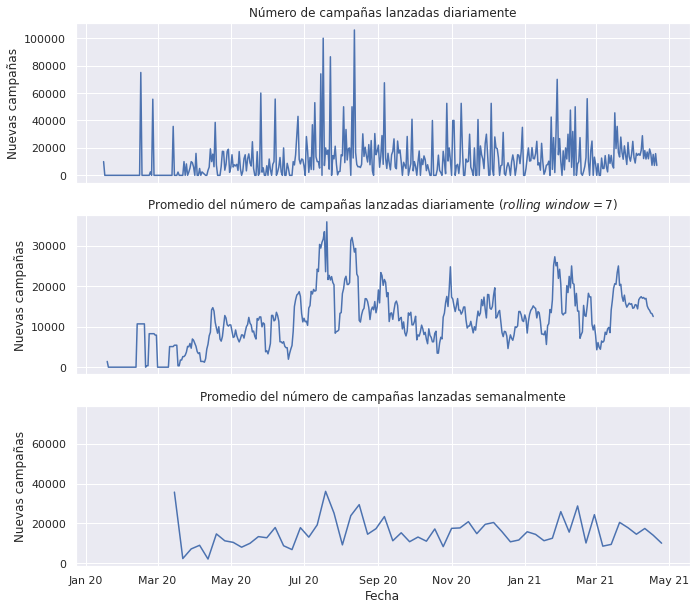

In [103]:
# Creamos una serie de tiempo a partir de los datos
serie_campaña= df[['launch_date', 'total amount in dollars']].groupby(['launch_date']).mean()['total amount in dollars']

#tomamos muestras semanales y calculamos el promedio sobre estas muestra
serie_diaria = serie_campaña.resample('D').sum()
serie_rolling = serie_diaria.rolling(window=7, center=True).mean()
serie_semanal = serie_campaña.resample('W').mean()

#Graficamos la serie de tiempo
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

#serie_diaria
axes[0].plot(serie_diaria)
axes[0].set_title('Número de campañas lanzadas diariamente')

#serie_rolling
axes[1].plot(serie_rolling)
axes[1].set_title(r'Promedio del número de campañas lanzadas diariamente $(rolling$ $window=7) $')

#serie_semanal
axes[2].plot(serie_semanal)
axes[2].set_title(r'Promedio del número de campañas lanzadas semanalmente')

# Dar formato a las fechas
for ax in axes:
    ax.set_ylabel('Nuevas campañas') #agregamos label en el eje y

axes[2].set_xlabel('Fecha')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.tight_layout
plt.show()